In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import seaborn as sns

import networkx as nx
import copy
import random
import getpass
import psycopg2 as ps
import os
import re

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters


In [2]:
df = pd.read_csv("")

## Make sure to remove edges with empty source or target

In [74]:
## CC is the empty Dict for number of connected components at time T
CC = {}
## NN is the empty Dict for number of nodes in the largest connected component at time T
NN = {}
## Clus_c empty dictionary for clustering coefficient
Clus_C = {}
## NE empty dictionary for number of edges
NE = {}
## Num_N empty dictionary for max possible edges
Max_E = {}
## Density ...
Den = {}
## Number of nodes in the entire network
Nu_N = {}

## avg number of nodes in clusters except the largest
Avg_N= {}

## Largest sns in source
SNS_S = {}

## Largest sns in target
SNS_T = {}

## Dictionary for list of number of nodes in each connect cluster at time T

NN_C = {}

## Difference between the number of nodes in the largest cluster vs the second largest cluster
diff = {}

second_large_cluster_node = {}

##################################################################################################################################

# Will be aggregating all the edges and nodes of the network by 1 day

for day, group_df in df.groupby(df['Day'].dt.date): 
     
        try:
            Graph = nx.from_pandas_edgelist(group_df, 'Source', 'Target')
            Graph_D = nx.from_pandas_edgelist(group_df, 'Source', 'Target', create_using=nx.DiGraph()) ## This creates a directed Graph
        except:
            pass
        CC[day] = nx.number_connected_components(Graph) ## Number of connected clusters
        
        NN_C_List = []    #Dictionary for list of number of nodes in each connect cluster at time T

        for c in nx.connected_components(Graph):  ## Number of nodes in each connected cluster
            NN_C_List.append(len(c))
            
            
                

        ## Sorting in descending to get the largest cluster at the top
        NN_C_List = sorted(NN_C_List,reverse= True)
       
        NN_C[day] = NN_C_List  
        try:
            diff[day] = NN_C_List[0] - NN_C_List[1]  ## Difference between the number of nodes in the largest and second largest connected cluster
        except:
            diff[day] = 0  ## For when there is only one connected cluster

        NN[day] = NN_C_List[0]  ## Number of nodes in the largest connected cluster
        Clus_C[day] = nx.average_clustering(Graph) ## Cluster coefficient of the graph
        NE[day]  = Graph_D.number_of_edges() ## Number of Edges
        Max_E[day] = (Graph.number_of_nodes()*(Graph.number_of_nodes()-1))/2 ## Max possible number of edges
        
        Den[day] = nx.density(Graph_D) ## Density
        
        Nu_N[day] = Graph.number_of_nodes() ## Number of Nodes
        try:
            Avg_N[day] = (Nu_N[day] -NN[day])/(CC[day]-1)   ## Average number of nodes in the network except the largest connected component 
        except: 
            Avg_N[day] = 0
        
        try:
            second_large_cluster_node[day] = NN_C_List[1]   ## Number of nodes in the second largest cluster
        except:
            second_large_cluster_node[day] = 0
        

        in_degree_centrality = nx.in_degree_centrality(Graph_D) 
        out_degree_centrality = nx.out_degree_centrality(Graph_D)

        #SNS_T[day]  = re.sub(r'[^a-zA-Z]', '', max(in_degree_centrality, key=in_degree_centrality.get))
        #SNS_S[day] = re.sub(r'[^a-zA-Z]', '', max(out_degree_centrality, key =out_degree_centrality.get) )
        

        



In [78]:
combined_dict = {key: [NN[key], CC[key],Clus_C[key],Nu_N[key],NE[key],Max_E[key],Den[key], Avg_N[key], SNS_S[key], SNS_T[key], NN_C[key], diff[key], second_large_cluster_node[key]] for key in NN}

In [80]:
Network_Metrics_Daily_Grouped_df = pd.DataFrame.from_dict(combined_dict, orient='index', columns=['Number of Nodes in the Largest Graph', 'Number of Connected Clusters', "Clustering Coefficient","Number of Nodes", "Number of Edges","Total possible Number of edges","Density" ,"Average Number of nodes in clusters except the largest", "Largest Source SNS", "Largest Target SNS", "Number of nodes in each independent cluster", "Difference between number of nodes in the largest and the second largest cluster", "Number of Nodes in the second largest cluster"] )


In [ ]:

Network_Metrics_Daily_Grouped_df.reset_index(inplace=True)
Network_Metrics_Daily_Grouped_df.rename(columns={'index': 'Date'}, inplace=True)
Network_Metrics_Daily_Grouped_df.head()

In [82]:
## Grouping by 3 days


grouped = df.groupby(pd.Grouper(key='Day', freq='3D'))

# Create dictionaries to store results for each 3-day interval
CC = {}
NN_C = {}
diff = {}
NN = {}
Clus_C = {}
NE = {}
Num_N = {}
Den = {}
Nu_N = {}
Avg_N = {}
second_large_cluster_node = {}
SNS_T = {}
SNS_S = {}

# Loop through the 3-day intervals
for interval_start, group_df in grouped:
    
    
    try:
        Graph = nx.from_pandas_edgelist(group_df, 'Source', 'Target')
        Graph_D = nx.from_pandas_edgelist(group_df, 'Source', 'Target', edge_attr="SNS Source", create_using=nx.DiGraph())
    except:
        pass
    
    CC[interval_start] = nx.number_connected_components(Graph)
    a = []
    NN_C_List = []
    for c in nx.connected_components(Graph):
        NN_C_List.append(len(c))
    
    # G is the number of nodes in the largest cluster
    NN_C_List = sorted(NN_C_List, reverse=True)
    NN_C[interval_start] = NN_C_List
    try:
        diff[interval_start] = NN_C_List[0] - NN_C_List[1]
    except:
        diff[interval_start] = 0

    NN[interval_start] = NN_C_List[0]
    Clus_C[interval_start] = nx.average_clustering(Graph)
    NE[interval_start] = Graph_D.number_of_edges()
    Num_N[interval_start] = (Graph.number_of_nodes() * (Graph.number_of_nodes() - 1)) / 2
    Den[interval_start] = nx.density(Graph_D)
    Nu_N[interval_start] = Graph.number_of_nodes()
    try:
        Avg_N[interval_start] = (Nu_N[interval_start] - NN[interval_start]) / (CC[interval_start] - 1)
    except:
        Avg_N[interval_start] = 0

    try:
        second_large_cluster_node[interval_start] = NN_C_List[1]
    except:
        second_large_cluster_node[interval_start] = 0

    in_degree_centrality = nx.in_degree_centrality(Graph_D)
    out_degree_centrality = nx.out_degree_centrality(Graph_D)

    SNS_T[interval_start] = re.sub(r'[^a-zA-Z]', '', max(in_degree_centrality, key=in_degree_centrality.get))
    SNS_S[interval_start] = re.sub(r'[^a-zA-Z]', '', max(out_degree_centrality, key=out_degree_centrality.get))

# Now, the dictionaries CC, NN_C, diff, NN, Clus_C, NE, Num_N, Den, Nu_N, Avg_N, second_large_cluster_node,
# SNS_T, and SNS_S contain results for each 3-day interval

In [83]:
combined_dict_3_days = {key: [NN[key], CC[key],Clus_C[key],Nu_N[key],NE[key],Num_N[key],Den[key], Avg_N[key], SNS_S[key], SNS_T[key], NN_C[key], diff[key], second_large_cluster_node[key]] for key in NN}

In [84]:
Network_Metrics_3_day_Grouped_df = pd.DataFrame.from_dict(combined_dict_3_days, orient='index', columns=['Number of Nodes in the Largest Graph', 'Number of Connected Clusters', "Clustering Coefficient","Number of Nodes", "Number of Edges","Total possible Number of edges","Density" ,"Average Number of nodes in clusters except the largest", "Largest Source SNS", "Largest Target SNS", "Number of nodes in each independent cluster", "Difference between number of nodes in the largest and the second largest cluster", "Number of Nodes in the second largest cluster"] )


In [ ]:
Network_Metrics_3_day_Grouped_df.reset_index(inplace=True)
Network_Metrics_3_day_Grouped_df.rename(columns={'index': 'Date'}, inplace=True)
Network_Metrics_3_day_Grouped_df.head()

In [89]:
merged_df = Network_Metrics_Daily_Grouped_df.merge(Network_Metrics_3_day_Grouped_df, left_index=True, right_index=True, suffixes=('_daily', '_3day'))


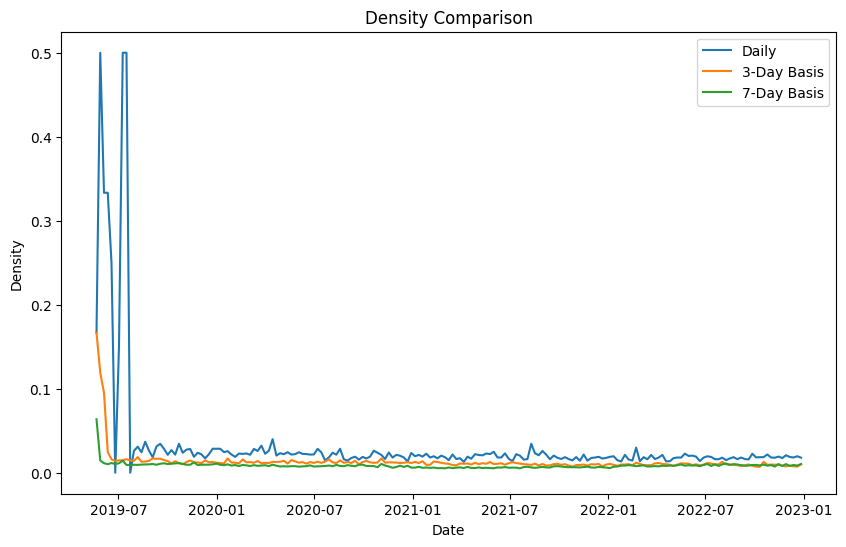

In [91]:
columns_to_plot = ['Number of Connected Clusters']  

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(merged_df["Date"], merged_df[column + '_daily'], label='Daily')
    plt.plot(merged_df["Date"], merged_df[column + '_3day'], label='3-Day Basis')
    
    
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(f'{column} Comparison')
    plt.legend()
    plt.show()

In [70]:
merged_df['ratio_daily'] = merged_df['Number of Nodes in the Largest Graph_daily'] / merged_df['Number of Nodes_daily']
merged_df['ratio_3day'] = merged_df['Number of Nodes in the Largest Graph_3day'] / merged_df['Number of Nodes_3day']
#merged_df['ratio_weekly'] = merged_df['Number of Nodes in the Largest Graph'] / merged_df['Number of Nodes']

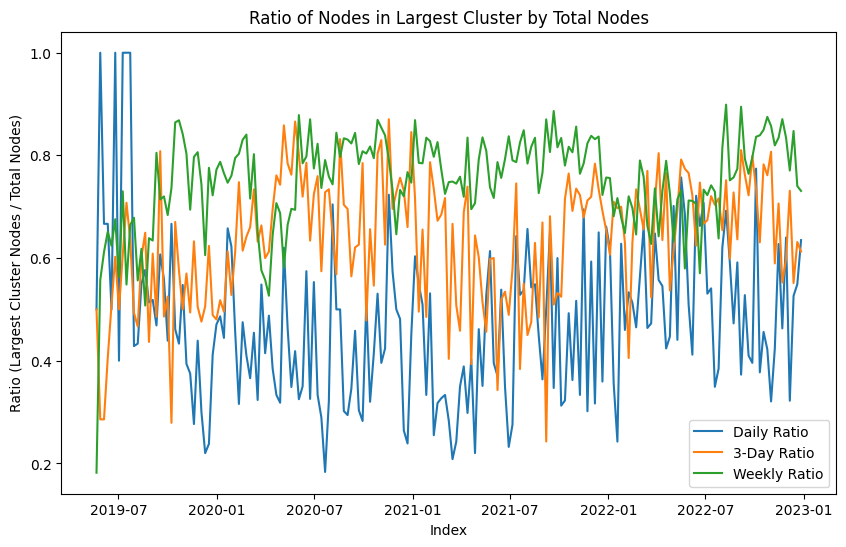

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df["Date"], merged_df['ratio_daily'], label='Daily Ratio')
plt.plot(merged_df["Date"], merged_df['ratio_3day'], label='3-Day Ratio')
plt.xlabel('Index')
plt.ylabel('Ratio (Largest Cluster Nodes / Total Nodes)')
plt.title('Ratio of Nodes in Largest Cluster by Total Nodes')
plt.legend()
plt.show()

In [53]:
merged_df.columns

Index(['Date_daily', 'Number of Nodes in the Largest Graph_daily',
       'Number of Connected Clusters_daily', 'Clustering Coefficient_daily',
       'Number of Nodes_daily', 'Number of Edges_daily',
       'Total possible Number of edges_daily', 'Density_daily',
       'Average Number of nodes in clusters except the largest_daily',
       'Largest Source SNS_daily', 'Largest Target SNS_daily',
       'Number of nodes in each independent cluster_daily',
       'Difference between number of nodes in the largest and the second largest cluster_daily',
       'Number of Nodes in the second largest cluster_daily', 'Date_3day',
       'Number of Nodes in the Largest Graph_3day',
       'Number of Connected Clusters_3day', 'Clustering Coefficient_3day',
       'Number of Nodes_3day', 'Number of Edges_3day',
       'Total possible Number of edges_3day', 'Density_3day',
       'Average Number of nodes in clusters except the largest_3day',
       'Largest Source SNS_3day', 'Largest Target SNS_3

In [67]:
## This code is for finding out the flow hierarchy of the network. Flow hierarchy simply just tells you whether the network has a tree like structure or not. The Higher the flow hierarchy number the more tree like structure it is.

Fl = {}


for day, groupdf in df.groupby(df['Day'].dt.date):
    Graph = nx.from_pandas_edgelist(groupdf, 'Source', 'Target',  create_using=nx.DiGraph())
    
    Fl[day] = nx.flow_hierarchy(Graph)

In [69]:
BC_df = pd.DataFrame.from_dict(Fl, orient= 'index', columns= ["Flow Hierarchy"])

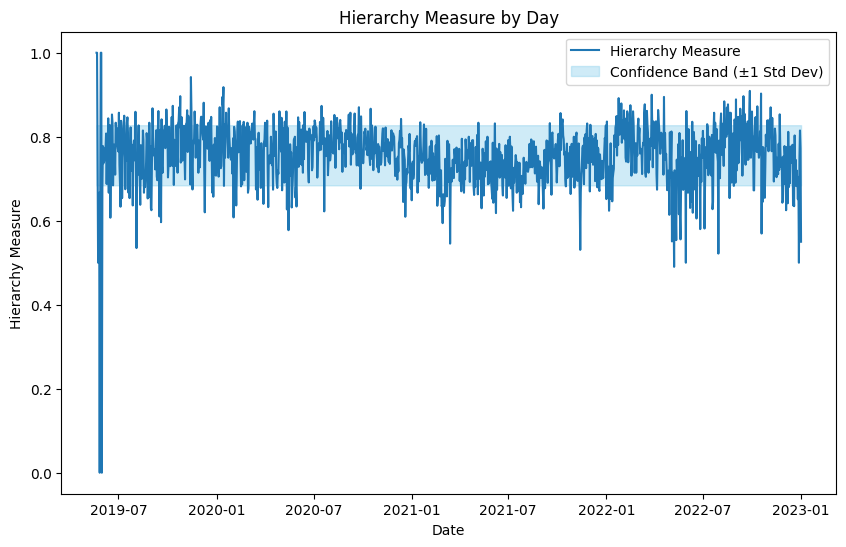

In [73]:
mean_hierarchy = BC_df['Flow Hierarchy'].mean()
std_dev_hierarchy = BC_df['Flow Hierarchy'].std()

plt.figure(figsize=(10, 6))
plt.plot(BC_df.index, BC_df['Flow Hierarchy'], label='Hierarchy Measure')
plt.fill_between(BC_df.index, mean_hierarchy - std_dev_hierarchy, mean_hierarchy + std_dev_hierarchy, color='skyblue', alpha=0.4, label='Confidence Band (±1 Std Dev)')

plt.xlabel('Date')
plt.ylabel('Hierarchy Measure')
plt.title('Hierarchy Measure by Day')
plt.legend()  # Add legend to the plot to label the hierarchy measure and confidence band

plt.show()

In [53]:
nx.flow_hierarchy(Graph)

0.4753745226671888

In [18]:
## Printing number of connected components - also called individual clusters
## These are aggregated over time
##print(nx.number_connected_components(Graph))


64


In [29]:
# Looping over all clusters to find the cluster with the highest number of nodes.
##a = []
##for c in nx.connected_components(Graph):
#   if len(c) > len(a):
#        a = c

## G is number of nodes in the largest cluster
# G = len(a)

In [125]:
print(Network_Metrics_Daily_Grouped_df.head(10))

df_metric = Network_Metrics_Daily_Grouped_df[225:925]

         Date  Number of Nodes in the Largest Graph  \
0  2019-05-21                                     2   
1  2019-05-22                                     2   
2  2019-05-24                                     2   
3  2019-05-25                                     2   
4  2019-05-26                                     2   
5  2019-05-27                                     1   
6  2019-05-28                                     2   
7  2019-05-29                                     2   
8  2019-05-30                                     2   
9  2019-05-31                                     1   

   Number of Connected Clusters  Clustering Coefficient  Number of Nodes  \
0                             2                     0.0                4   
1                             1                     0.0                2   
2                             2                     0.0                3   
3                             2                     0.0                3   
4             

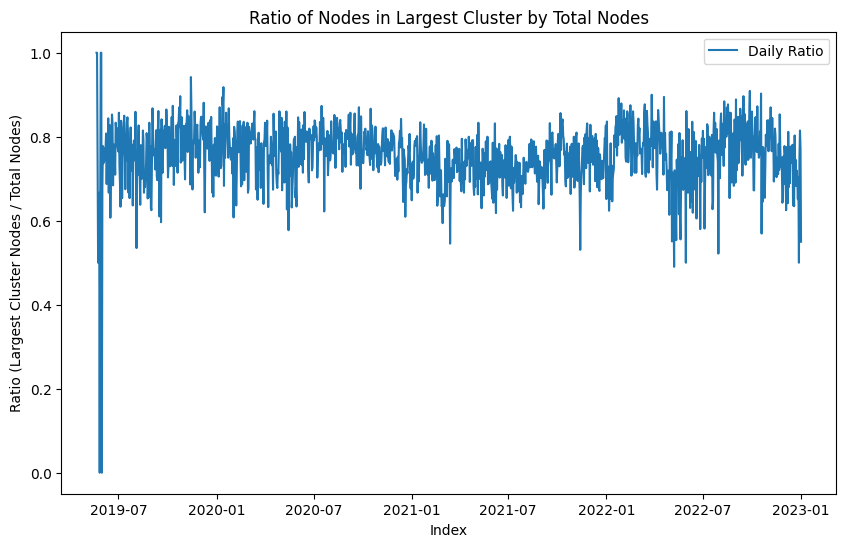

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(df_metric['Date'], df_metric['Number of Edges'], label='Daily Ratio')

plt.xlabel('Index')
plt.ylabel('Ratio (Largest Cluster Nodes / Total Nodes)')
plt.title('Ratio of Nodes in Largest Cluster by Total Nodes')
plt.legend()
plt.show()

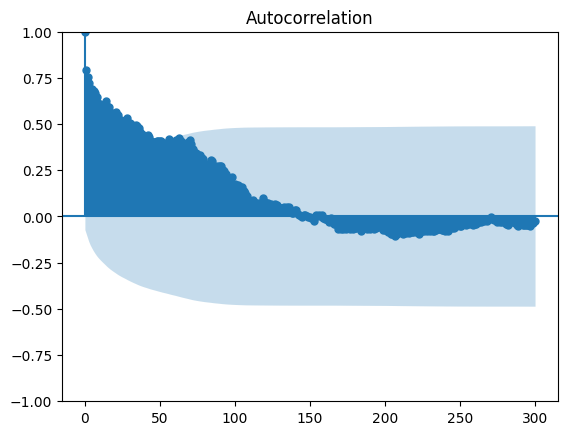

In [147]:
acf_plot = plot_acf(df_metric["Number of Edges"], lags= 300)